In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math




/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [103]:
with open('val_err_wo_lr_decay.json') as f:
    val_acc = json.load(f)

min_delta = 1e-3
patience = 15
smooth_win_size = 40
num_epochs_between_eval = 20

val_err = 1 - np.array(val_acc)
smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

minEpoch = (np.argmin(smoothed_val_err)+1)*20
print(minEpoch, np.min(smoothed_val_err), len(smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, smoothed_val_err[earlyStoppingStep//20+1])

steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
weights = np.ones(len(smoothed_val_err))
predictedEarlyStoppingStep, a, b = early_stopping_prediction(steps[:len(smoothed_val_err)], smoothed_val_err, min_delta, patience, weights=weights)

print(predictedEarlyStoppingStep)

7880 0.32597560998870106 512
3840 0.3732439003339629
2642.0


<IPython.core.display.Javascript object>


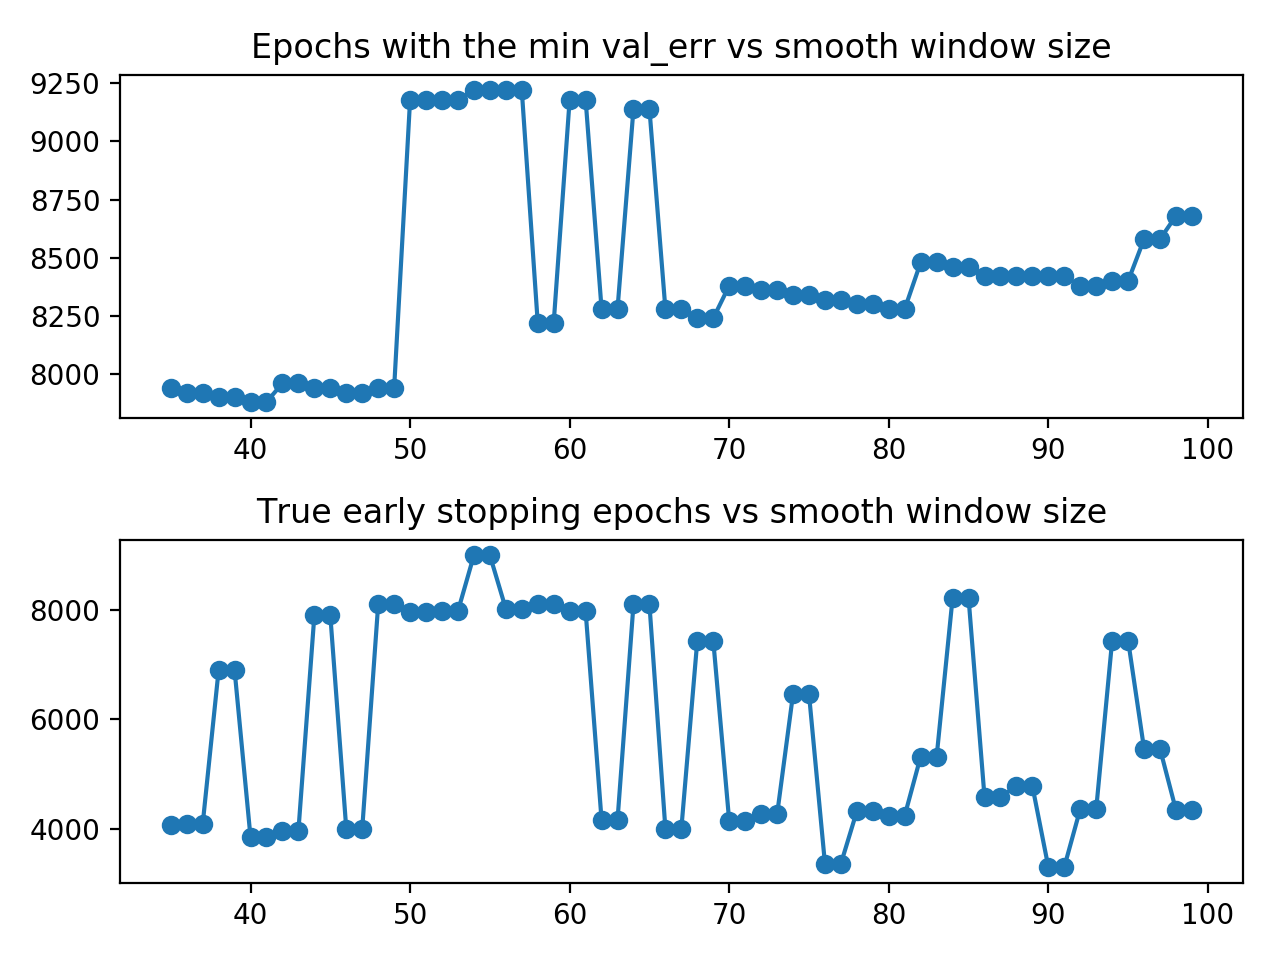

In [104]:
minEpochs = []
earlyStoppingSteps = []
x = range(35,100)
for i in x:
    smoothed_val_err_ = smooth_by_linear_filter(val_err, i)
#     print(smoothed_val_err_)
    minEpochs.append((np.argmin(smoothed_val_err_)+1)*20)
    earlyStoppingSteps.append(early_stopping_step(val_err, min_delta, patience, i, num_epochs_between_eval))


fig = plt.figure()
ax = plt.subplot(212)
ax.plot(x, earlyStoppingSteps, '-o')
ax.set_title('True early stopping epochs vs smooth window size')

ax = plt.subplot(211)
ax.plot(x, minEpochs, '-o')
ax.set_title('Epochs with the min val_err vs smooth window size')

fig.tight_layout()

In [4]:
# The early stopping epoch acquired by the criteria is very sensitive to smooth window size
# but epochs with min validation error is less sensitive
# the regression line and regression-predicted stopping epoch is not sensitive to smooth window size

<IPython.core.display.Javascript object>


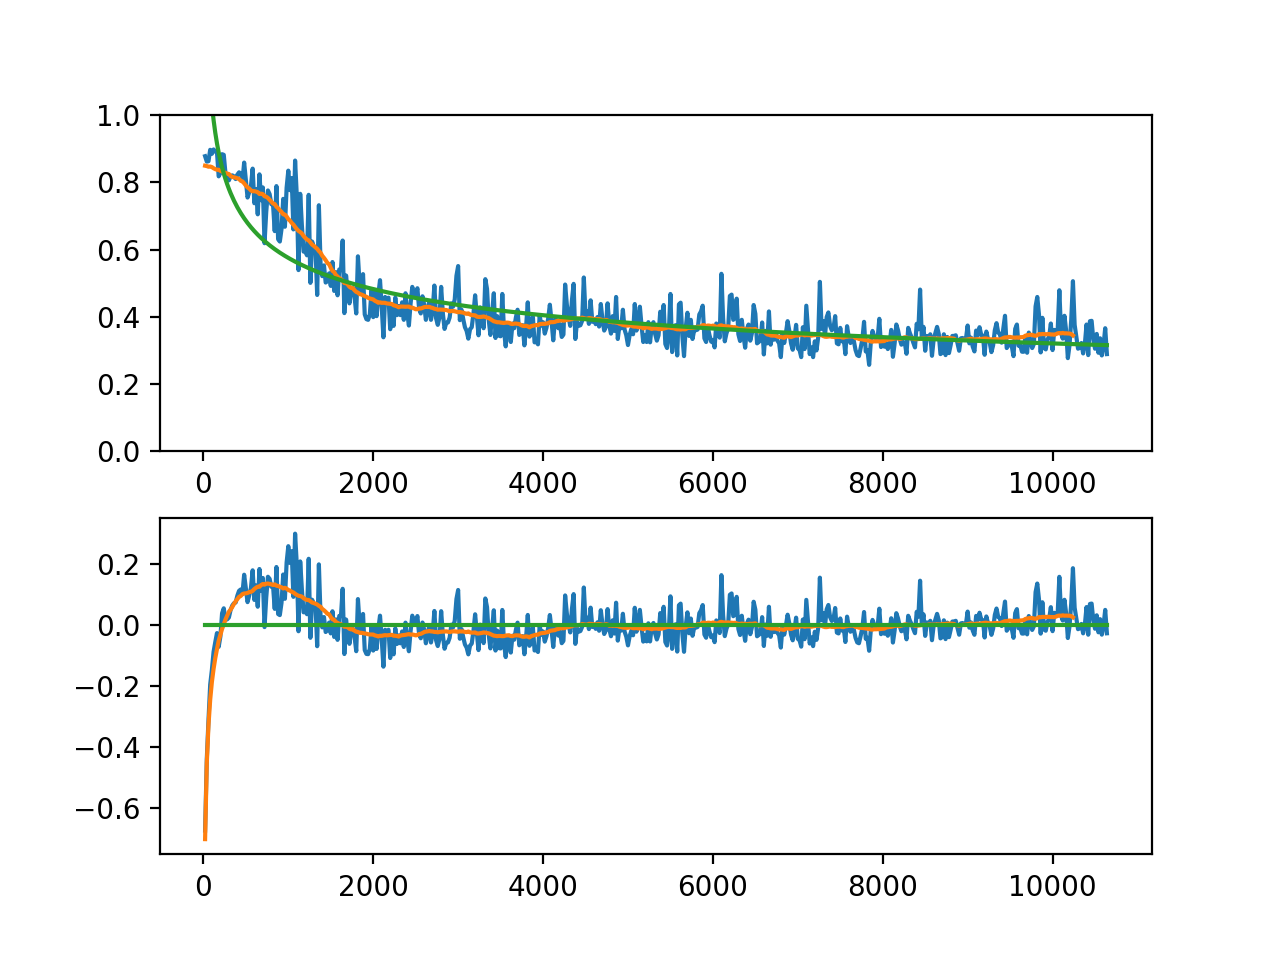

In [105]:
plt.figure()
ax = plt.subplot(211)
ax.plot(steps, val_err)
ax.plot(steps[:len(smoothed_val_err)], smoothed_val_err)
ax.plot(steps, a*np.power(steps,b))
ax.set_ylim(0,1)


ax = plt.subplot(212)
ax.plot(steps, val_err-a*np.power(steps,b))
ax.plot(steps[:len(smoothed_val_err)], smoothed_val_err-a*np.power(steps[:len(smoothed_val_err)],b))
ax.plot(steps, np.zeros(len(steps)))

def _power(a,b,x):
    return a*np.power(x,b)

# print(_power(a,b,2864)- _power(a,b,2884) < min_delta)

In [107]:
# The noise can be viewed as guassian


207


/Users/stranot/qfdong/research/simulate_online_regression/utils.py:70: RuntimeWarning: divide by zero encountered in power
  return abs(a*np.power(x,b) - a*np.power(x+n,b)) < delta


<IPython.core.display.Javascript object>


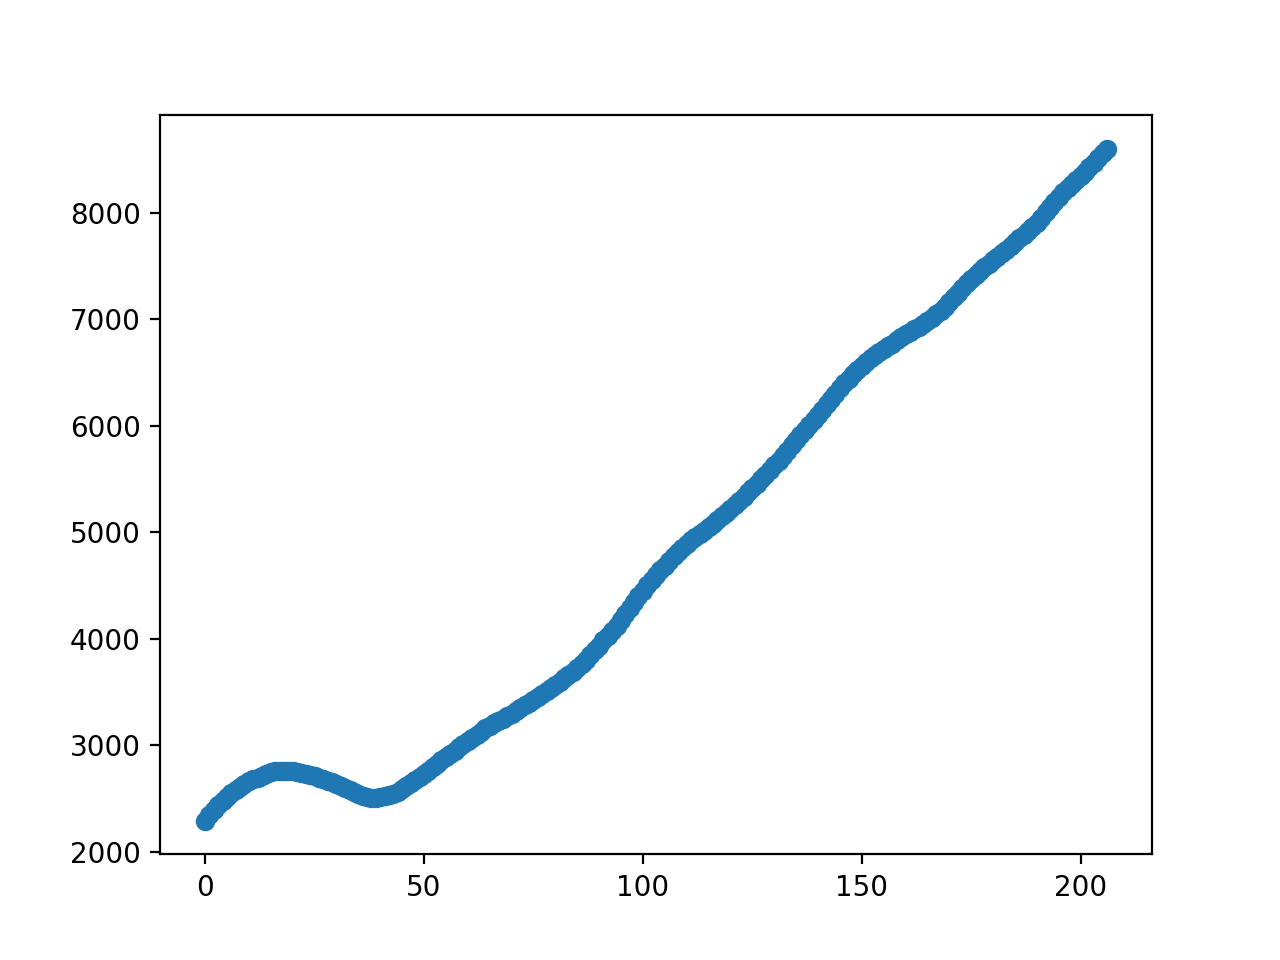

In [108]:
pred_win_size = 100
left_tail_size = 0
period = 2
start_point = 100
pred_min_delta = min_delta
wtype = 'linear'

preds, coeffs, shifts = sim_online_early_stopping_prediction(
                                    smoothed_val_err,
#                                     val_err,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    start_point = start_point,
                                    weights_type = wtype)
print(len(preds))

plt.figure()
plt.plot(range(len(preds)), preds, '-o')

<IPython.core.display.Javascript object>


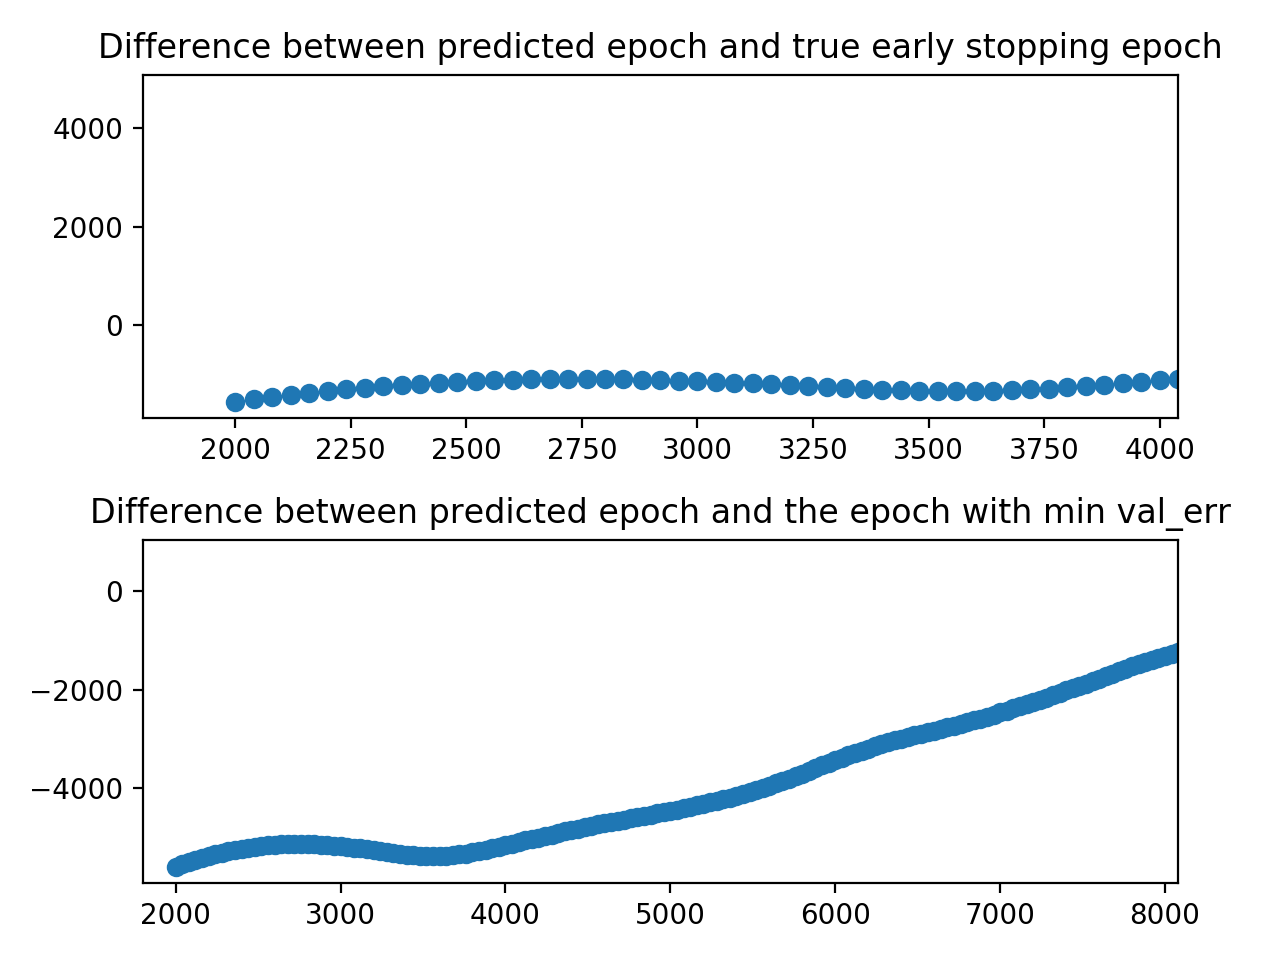

In [109]:
fig = plt.figure()
ax = plt.subplot(211)
# ax.set_xlim(7500,10500)
# ax.set_ylim(-2000,0)
ax.plot((start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval,np.array(preds)-earlyStoppingStep, 'o')
ax.set_xlim(1800, earlyStoppingStep+200)
ax.set_title('Difference between predicted epoch and true early stopping epoch')

ax = plt.subplot(212)
# ax.set_xlim(7500,10500)
# ax.set_ylim(-2000,0)
ax.plot((start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval,np.array(preds)-minEpoch, 'o')
ax.set_xlim(1800, minEpoch+200)
ax.set_title('Difference between predicted epoch and the epoch with min val_err')

fig.tight_layout()

<IPython.core.display.Javascript object>


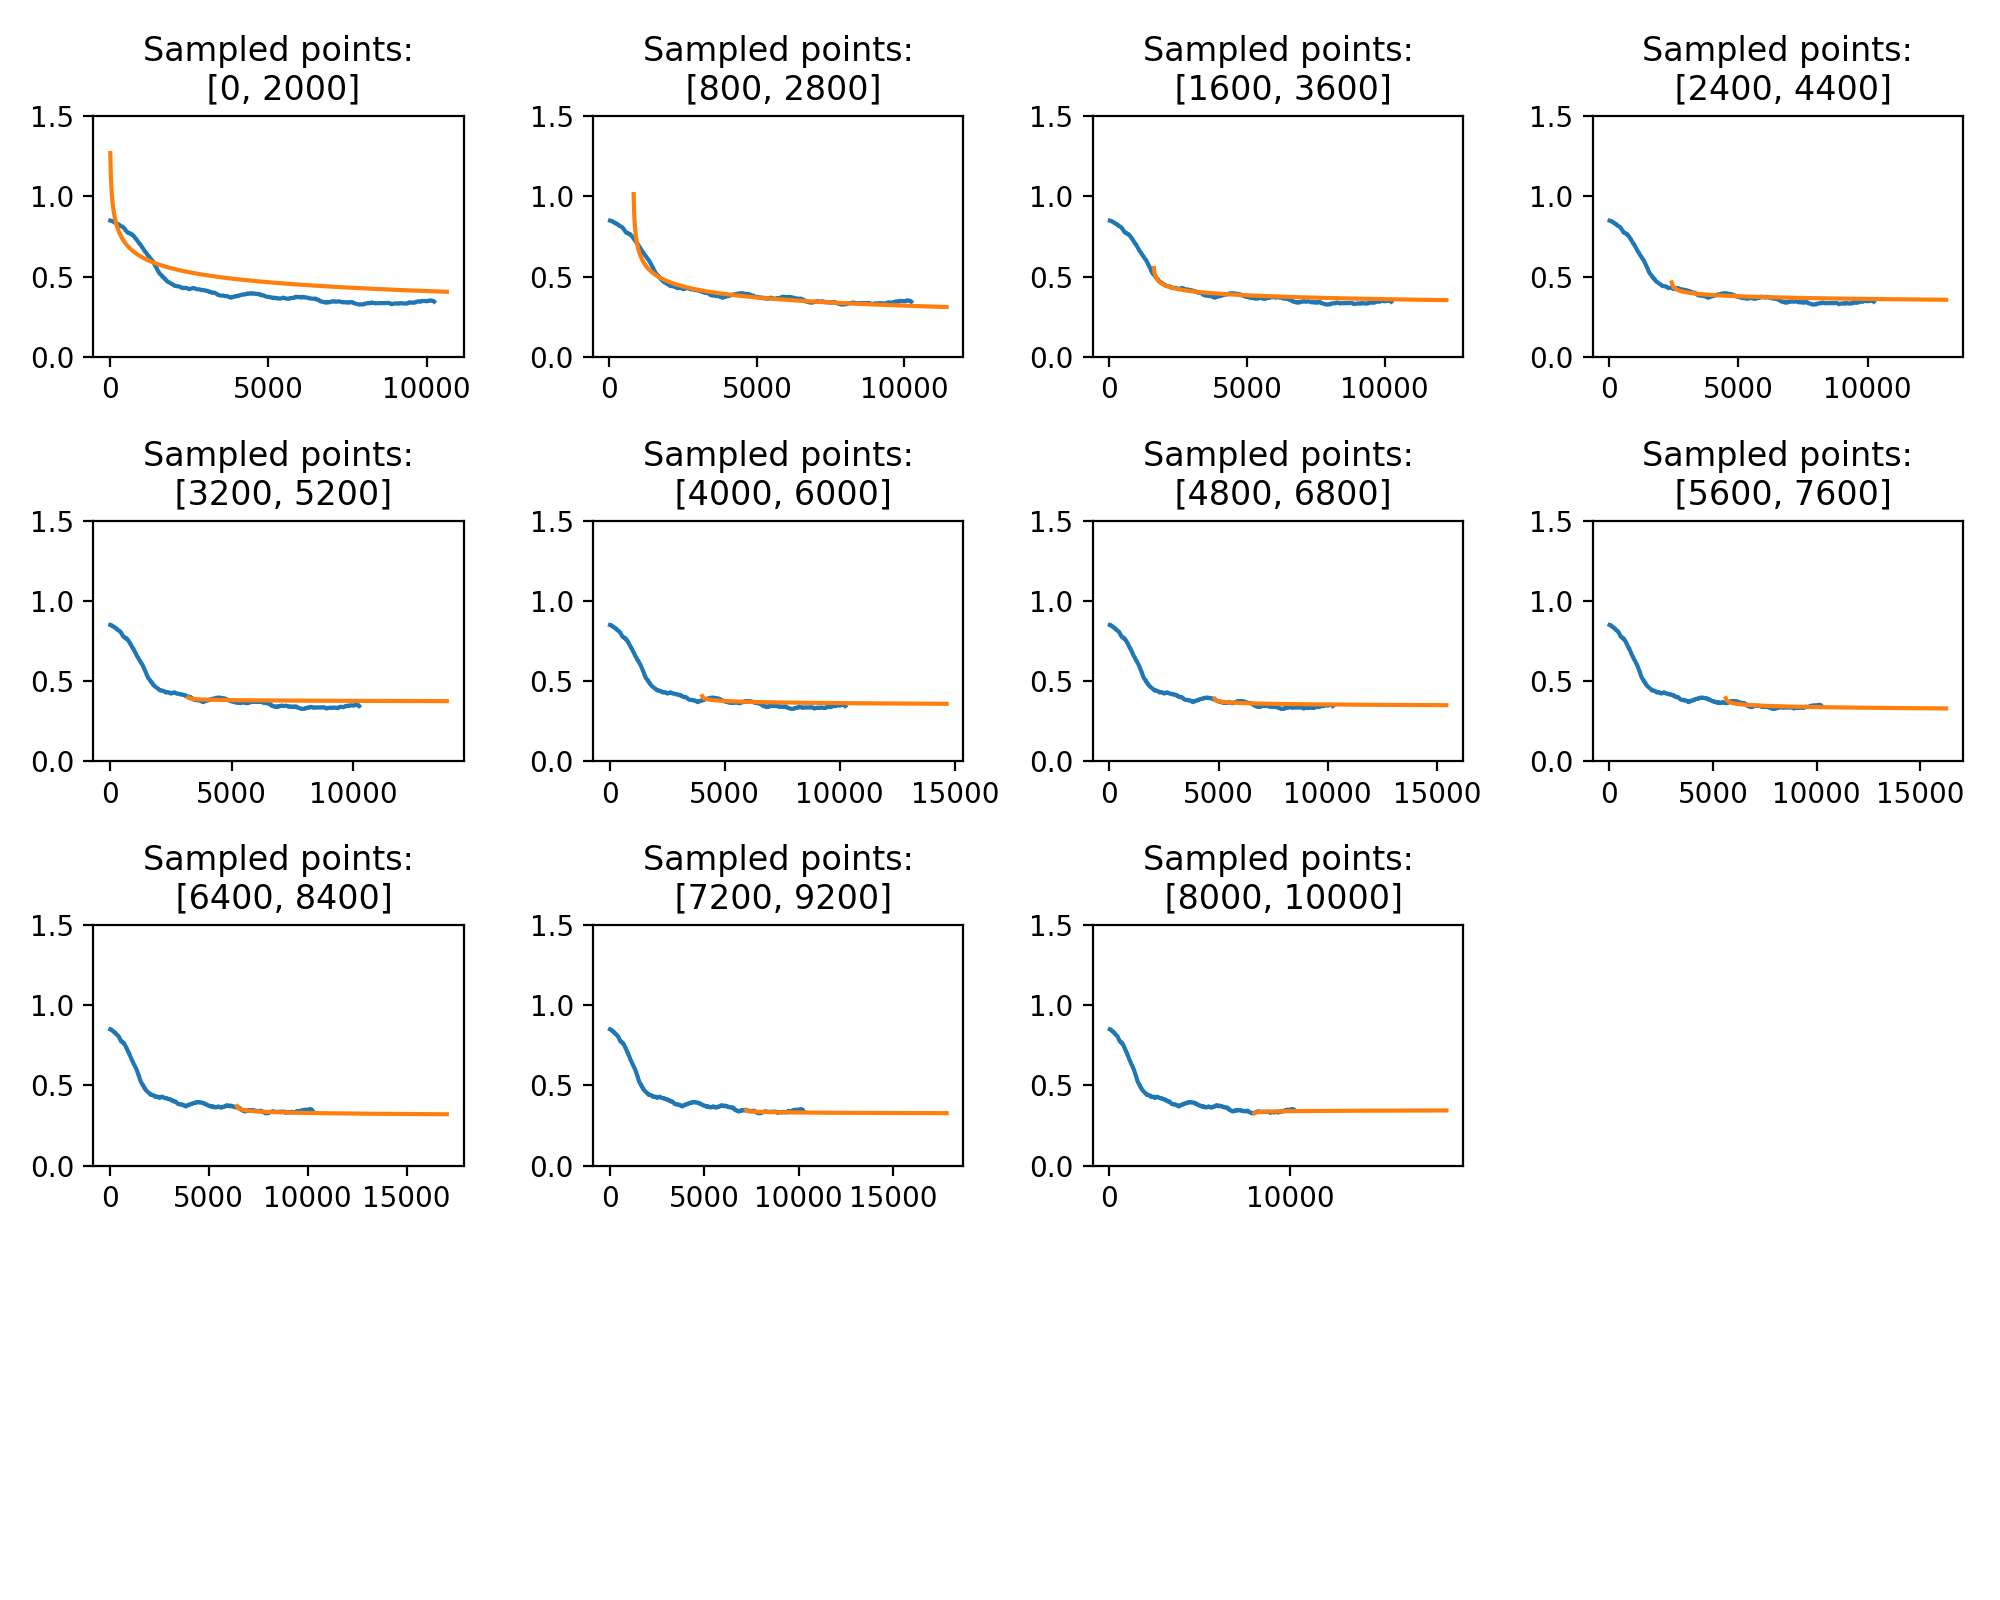

In [110]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 20
for i in range(0,len(coeffs),step_size):
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    plt.plot(steps[:len(smoothed_val_err)], smoothed_val_err)
#     ax.plot(steps, coeffs[i][0]*np.power(steps,coeffs[i][1]))
    ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled points:\n [{}, {}]'.format(s,e))
    
fig.tight_layout()    

<IPython.core.display.Javascript object>


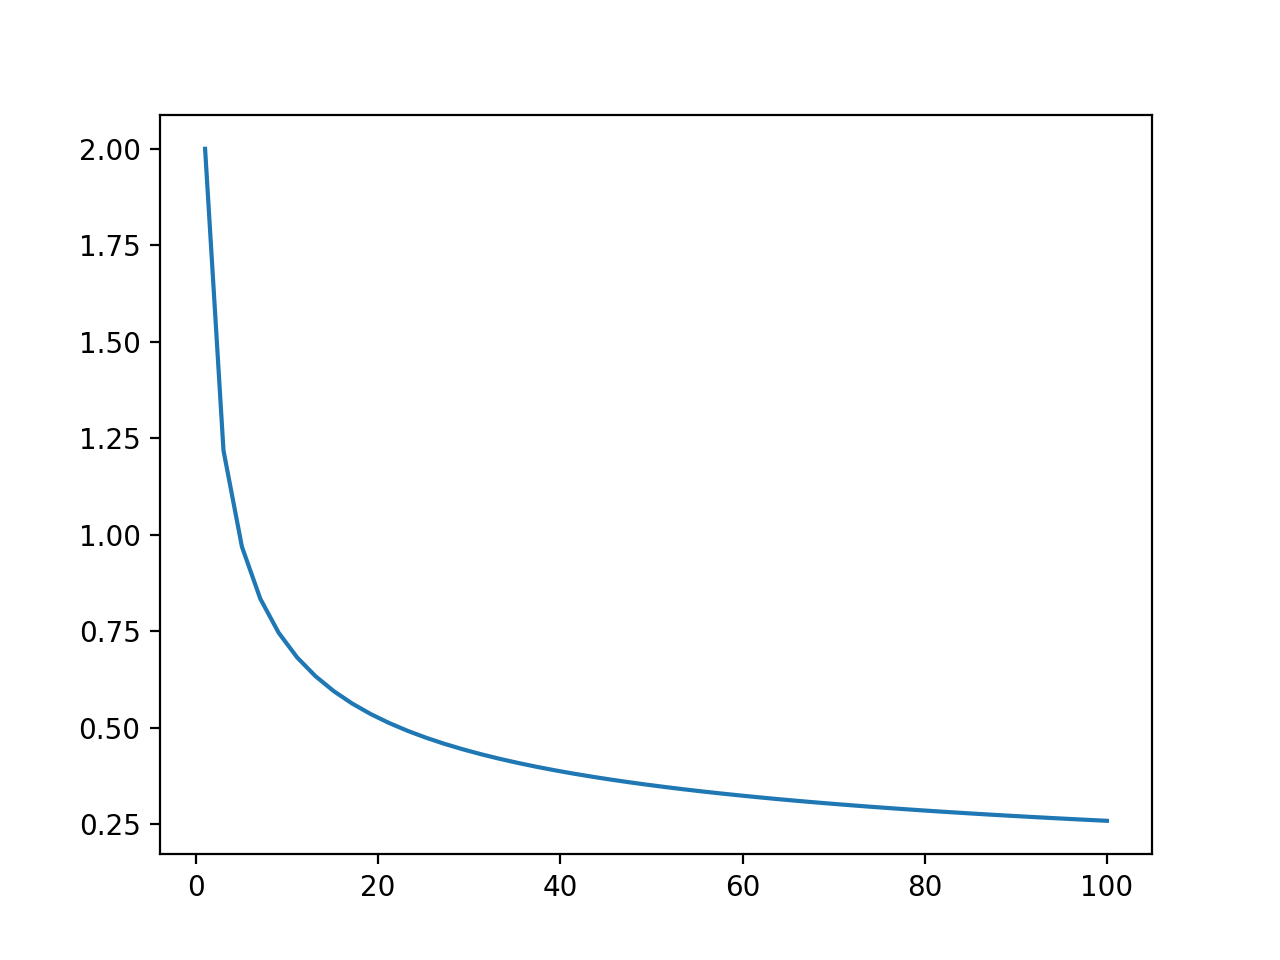

In [37]:
x = np.linspace(1,100)
y = np.power(x,-0.5)+np.power(x,-0.4)

plt.figure()
plt.plot(x,y)